In [49]:
# basic imports and setup

import os
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# makes CUDA errors easier to trace
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# dataset location
RAW_DATA_ROOT = Path(
    r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\data\raw\DeepPCB"
)

# train / test split files
train_split = RAW_DATA_ROOT / "trainval.txt"
test_split  = RAW_DATA_ROOT / "test.txt"

# training params
IMAGE_SIZE   = 224
BATCH_SIZE   = 32
NUM_WORKERS  = 0
PIN_MEMORY   = False
LR           = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS   = 2

# pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("cpu")


NVIDIA GeForce RTX 4060 Laptop GPU


In [50]:
# image transforms for training and validation

from torchvision import transforms as T
from PIL import Image

# used during training
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# used for validation / testing
val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# dataset for DeepPCB patch-based data
class DeepPCBPatchDataset(Dataset):

    def __init__(self, root_dir, split_file, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        # split file has image path and annotation path per line
        with open(split_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 2:
                    continue

                img_rel, ann_rel = parts
                img_path = self.root_dir / img_rel
                ann_path = self.root_dir / ann_rel

                # handle renamed images if present
                if not img_path.exists():
                    alt_img_path = img_path.with_name(
                        img_path.stem + "_temp" + img_path.suffix
                    )
                    if alt_img_path.exists():
                        img_path = alt_img_path
                    else:
                        continue

                if not ann_path.exists():
                    continue

                # read bounding boxes from annotation file
                with open(ann_path, "r") as af:
                    for line in af:
                        x_min, y_min, x_max, y_max, cls_id = map(
                            int, line.strip().split()
                        )

                        # store one patch per bounding box
                        self.samples.append(
                            (img_path, (x_min, y_min, x_max, y_max), cls_id - 1)
                        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, bbox, cls_id = self.samples[idx]

        img = Image.open(img_path).convert("RGB")

        # crop defect area
        x_min, y_min, x_max, y_max = bbox
        patch = img.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            patch = self.transform(patch)

        return patch.float(), torch.tensor(cls_id, dtype=torch.long)


In [51]:


NUM_CLASSES = len(class_names)   

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

MODEL_PATH = Path(
    r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\models\best_pcb_model.pth"
)

model.load_state_dict(
    torch.load(MODEL_PATH, map_location=device)
)

model = model.to(device)
model.eval()

print(" Model loaded successfully")


 Model loaded successfully


C:\Users\TUSHAR\AppData\Local\Temp\ipykernel_31668\637360124.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(MODEL_PATH, map_location=device)


In [ ]:


# Validation / test dataset (used for Grad-CAM)
val_dataset = DeepPCBPatchDataset(
    root_dir=RAW_DATA_ROOT,
    split_file=test_split,
    transform=val_transform
)

print("Validation dataset created")
print("Number of samples:", len(val_dataset))


Validation dataset created
Number of samples: 3140


In [52]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM

GRADCAM_DIR = Path(
    r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs"
)
GRADCAM_DIR.mkdir(parents=True, exist_ok=True)

# Setup Grad-CAM on last conv block
target_layer = model.layer4[-1]

gradcam = GradCAM(
    model=model,
    target_layers=[target_layer]
)




🧩 PCB: 20085291_temp | Defects: 9


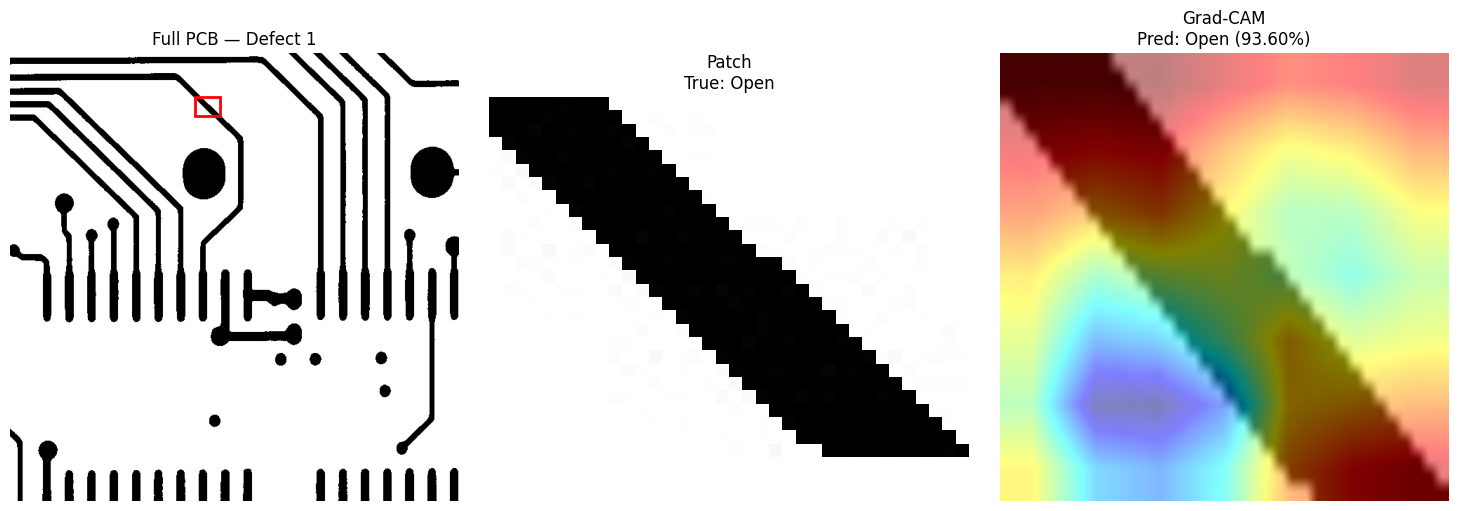

   ✔ Saved → C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs\20085291_temp\defect_1_Open.png


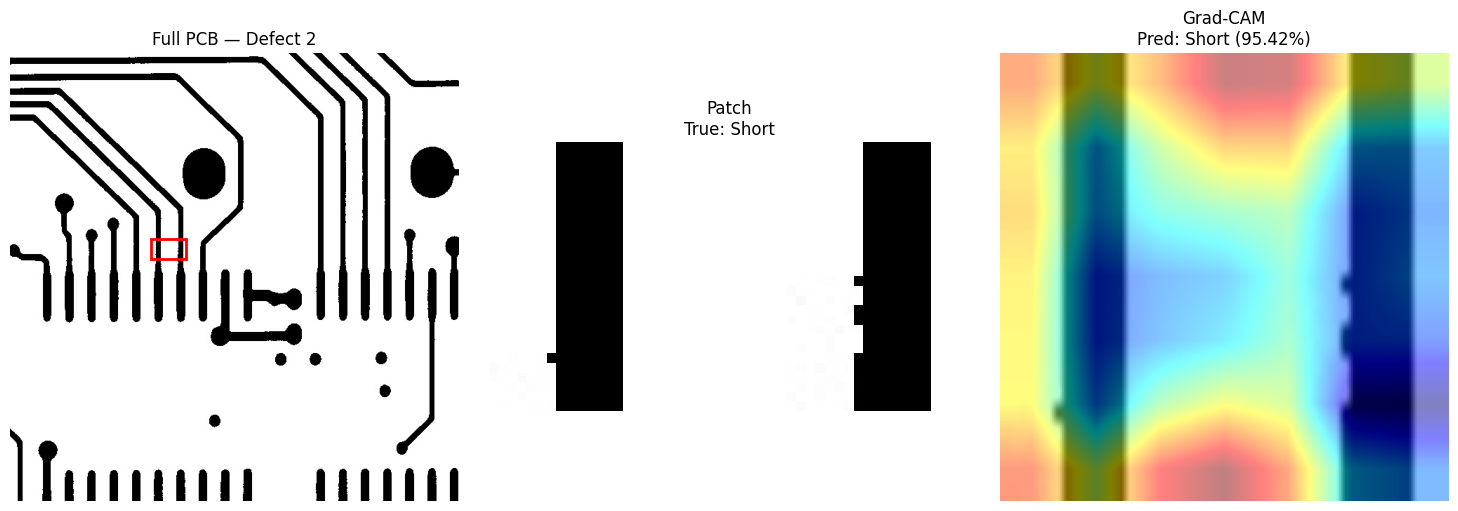

   ✔ Saved → C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs\20085291_temp\defect_2_Short.png


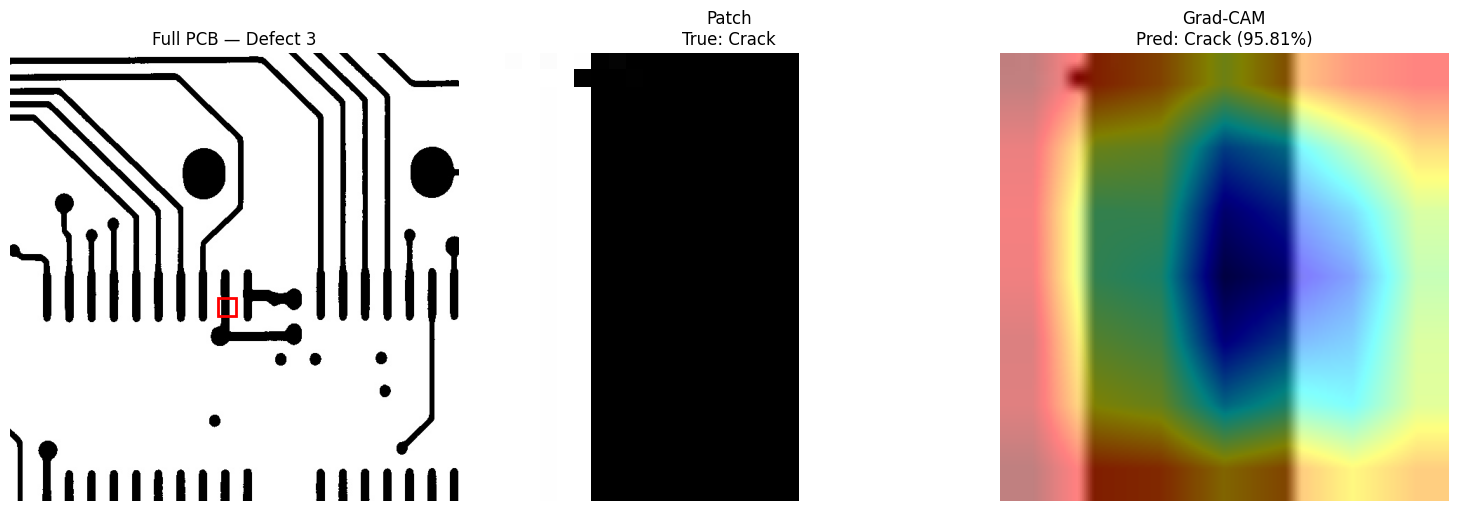

   ✔ Saved → C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs\20085291_temp\defect_3_Crack.png


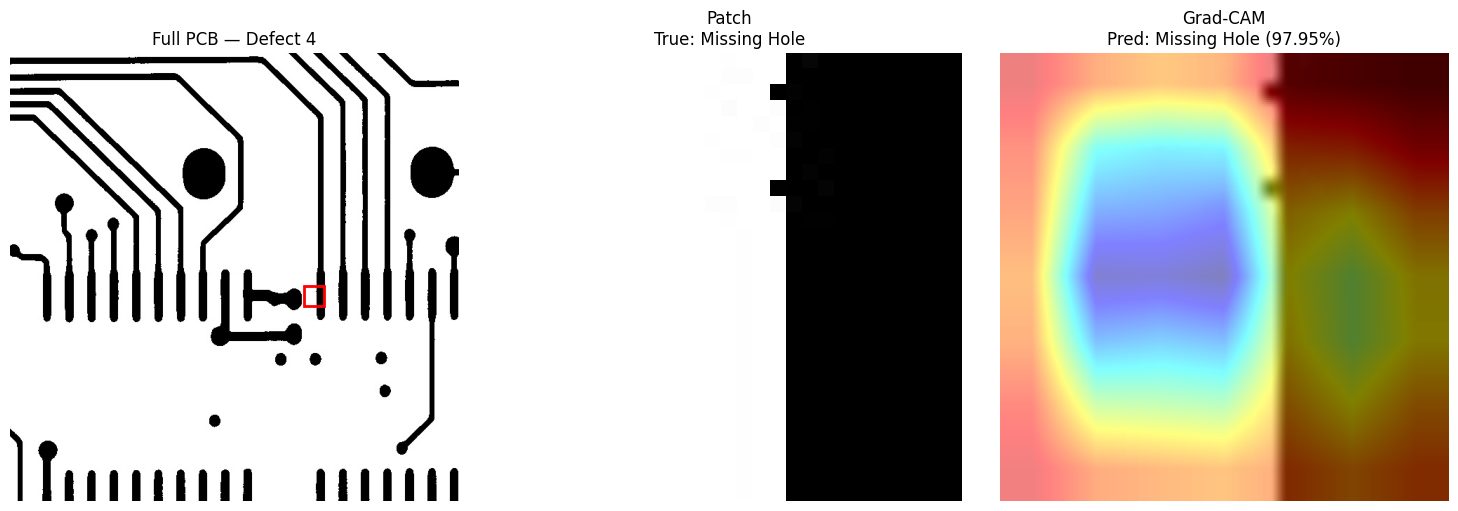

   ✔ Saved → C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs\20085291_temp\defect_4_Missing Hole.png


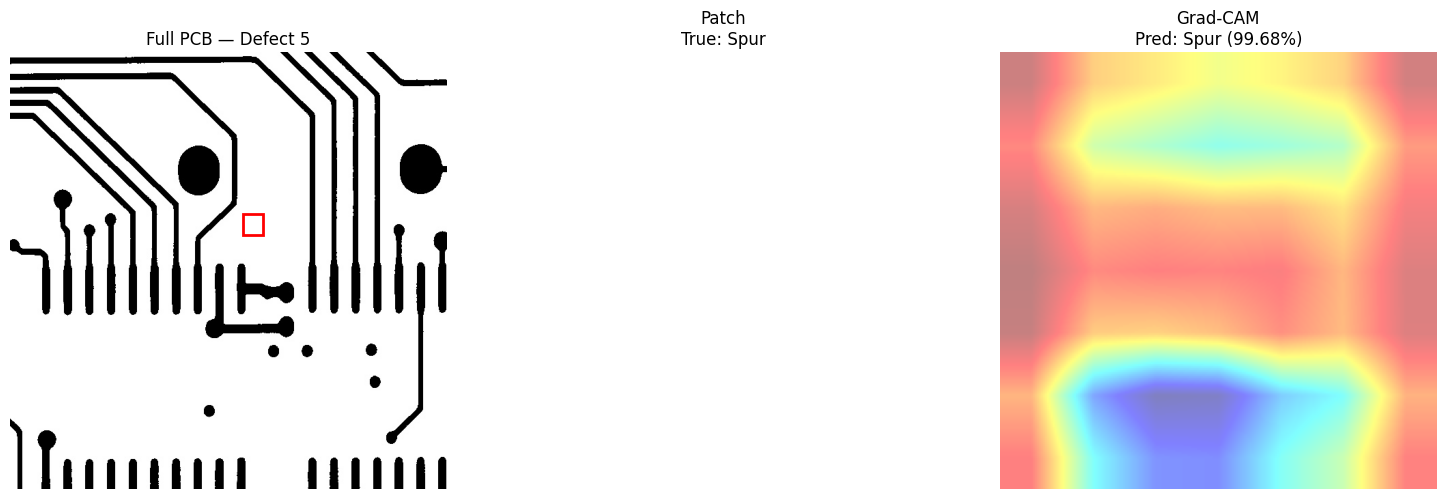

   ✔ Saved → C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\gradcam_outputs\20085291_temp\defect_5_Spur.png
✅ Completed Grad-CAM for PCB: 20085291_temp



In [55]:

visualize_full_pcb_gradcam(
    dataset=val_dataset,   
    img_index=0,
    model=model,
    gradcam=gradcam,
    class_names=class_names,
    device=device,
    transform=val_transform,
    display_limit=5
)
